Step 1:
EDA STEPS:
1.Indexing data

2.Visualize data(check the statistical data for each column)

3.Barchart/piechart(default rate in different regions, default rate in different types)

4.Attribute(numeric(correlation),rank the top 10 correlation),
EDA
https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction
simple histogram and distribution.

5. Correlation (with the target varaible)

Step 2:
toy_data = df.head(100)

pre-processing
missing value (impute(), delete,)
categorical varaible (onehot encoding)
outlier

Step 3:
Model:

1.Naive-Bayes

2.Logistic regression

3.Neuro Network

4.Decision tree

5. Random Forest
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

6. Adaboost
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

Step 3:
Evaluate the model and compare it
cross_val_score
accuracy, sensitivity...

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics


In [1]:
##Thanks for Janio Alexander's code

##importing packages and data
import pandas as pd
import numpy as np
loan=pd.read_csv('/Users/taotao/Desktop/loan/loan.csv',low_memory=False)
loan_original=loan.copy()

##import packages for visualizing data
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

##visualize data
loan.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
# Number of each type of column
loan.dtypes.value_counts()

float64    49
object     23
int64       2
dtype: int64

In [3]:
# select a random sample to run the analysis faster
random_sample = loan.sample( n = 10000)

In [4]:
##drop some unrelated columns 
random_sample.drop(['id', 'member_id', 'emp_title', 'url', 'desc', 'zip_code', 'title'], axis=1, inplace=True)

In [5]:
# dealing with missing value
# drop columns with over 90% of null values, those variables won't help with the later analysis
random_sample = random_sample.replace([0,' ','NULL'],np.nan)
random_sample = random_sample.dropna(thresh=1000,how='all',axis=1)

In [6]:
random_sample.isnull().sum()

loan_amnt                         0
funded_amnt                       0
funded_amnt_inv                   1
term                              0
int_rate                          0
installment                       0
grade                             0
sub_grade                         0
emp_length                      561
home_ownership                    0
annual_inc                        0
verification_status               0
issue_d                           0
loan_status                       0
pymnt_plan                        0
purpose                           0
addr_state                        0
dti                               5
delinq_2yrs                    8166
earliest_cr_line                  0
inq_last_6mths                 5577
mths_since_last_delinq         5152
mths_since_last_record         8500
open_acc                          0
pub_rec                        8500
revol_bal                        38
revol_util                       41
total_acc                   

In [7]:
# for the columns with less than 90% null-value, I used different methods to fill them
# for the dates with null value, in order to do the later analysis, fill the missing data with some impossible number to help identify them later
r2 = random_sample.fillna({'last_pymnt_d':'Dec-1900','next_pymnt_d':'Dec-2100'})
# in order to keep enough variables, I decide to keep filling other null value 
random_sample=random_sample.fillna(method='ffill')

In [8]:
# create loan_status indicator
# 1: notcurent
# 0: current
random_sample["loan_status_ind"] = np.where(random_sample["loan_status"] != "Current",'0','1') 

In [9]:
random_sample["loan_status_ind"].value_counts()

1    6722
0    3278
Name: loan_status_ind, dtype: int64

In [10]:
# Number of unique classes in each object column(check the categorical columns)
random_sample.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

term                     2
grade                    7
sub_grade               35
emp_length              11
home_ownership           4
verification_status      3
issue_d                 96
loan_status             10
pymnt_plan               1
purpose                 14
addr_state              48
earliest_cr_line       514
initial_list_status      2
last_pymnt_d            79
next_pymnt_d            29
last_credit_pull_d      71
application_type         2
loan_status_ind          2
dtype: int64

1. grade and sub_grade is not the predictable variable, so here I just delete the grade and sub_grade column.

2. to simplify our model, I also delete the address state variable, becasue geographical factor doesn't really related to the loan condition.

3. for some varaible with too many an objects such as dates, I use some actually days to represent the variable


In [11]:
# decrease the dimension of addr_state
random_sample['addr_state'].unique()

# Make a list with each of the regions by state.

west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
south_west = ['AZ', 'TX', 'NM', 'OK']
south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']



random_sample['region'] = np.nan

def finding_regions(state):
    if state in west:
        return 'West'
    elif state in south_west:
        return 'SouthWest'
    elif state in south_east:
        return 'SouthEast'
    elif state in mid_west:
        return 'MidWest'
    elif state in north_east:
        return 'NorthEast'
    


random_sample['region'] = random_sample['addr_state'].apply(finding_regions)

In [12]:
# decrease the dimension of the object colunms
earliest_cr_line=pd.to_datetime(random_sample['earliest_cr_line'])
random_sample['today']='Jan-2016'
today=pd.to_datetime(random_sample['today'])
random_sample['credit_age']=today-earliest_cr_line

In [13]:
## transfer object to datetime
## ????should I also transfer them into months? or date is just ok
issue_d=pd.to_datetime(random_sample['issue_d'])
last_credit_pull_d=pd.to_datetime(random_sample['last_credit_pull_d'])
last_pymnt_d=pd.to_datetime(r2['last_pymnt_d'])
next_pymnt_d=pd.to_datetime(r2['next_pymnt_d'])


# clean the data
# I already create the loan_status_ind to present the good loan and bad loan, so I also deleted the original column
random_sample.drop(['grade','sub_grade','addr_state','loan_status'],axis=1,inplace=True)

# use a different way to interpret date data
random_sample['credit_card_length']=last_credit_pull_d-issue_d
random_sample['pymnt_interval']=next_pymnt_d-last_pymnt_d


# drop the original date data to decrease the number of features
random_sample.drop(['issue_d','last_credit_pull_d','last_pymnt_d','next_pymnt_d','today','earliest_cr_line'],axis=1,inplace=True)


In [14]:
random_sample['pymnt_interval']

438881      31 days
465734   31533 days
595030      31 days
282708      31 days
347660      62 days
437084      31 days
656534      62 days
468848   42034 days
234703      31 days
704282      31 days
742352      31 days
480300   42065 days
765773      31 days
856880   31199 days
544931      31 days
52371       31 days
71122    31199 days
670362      62 days
76916       62 days
444961   31137 days
407742   31290 days
549664      31 days
665059       0 days
493572      31 days
280303      31 days
742571      62 days
111668      31 days
771848      62 days
154887   31625 days
825291      31 days
            ...    
697892   31137 days
621236      31 days
92882    31290 days
587740      31 days
841445      31 days
16083    32079 days
772691      31 days
406718       0 days
787041      31 days
178883   31046 days
751742      31 days
282376      31 days
605833      31 days
474305   42065 days
280005   31199 days
164916   31564 days
687663      31 days
875354   31137 days
663153      31 days


In [15]:
# change the timedelta I created to float in order to do the further analysis
random_sample['pymnt_interval']=random_sample['pymnt_interval'].astype('timedelta64[D]')
random_sample['credit_age']=random_sample['credit_age'].astype('timedelta64[D]')
random_sample['credit_card_length']=random_sample['credit_card_length'].astype('timedelta64[D]')

In [16]:
# Because I fill the missing value of last payment day and next payment day with impossible numbers
# I identified those impossible numbers as missing value again.
pymnt_interval2=random_sample['pymnt_interval']
pymnt_interval2.where(pymnt_interval2>100,31)
random_sample['pymnt_interval']=pymnt_interval2

In [17]:
random_sample.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

term                    2
emp_length             11
home_ownership          4
verification_status     3
pymnt_plan              1
purpose                14
initial_list_status     2
application_type        2
loan_status_ind         2
region                  5
dtype: int64

In [18]:
## Encoding Catergorical variables
# one-hot encoding of categorical variables
random_sample2 = pd.get_dummies(random_sample)

In [21]:
random_sample2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 438881 to 785743
Data columns (total 77 columns):
loan_amnt                              10000 non-null float64
funded_amnt                            10000 non-null float64
funded_amnt_inv                        10000 non-null float64
int_rate                               10000 non-null float64
installment                            10000 non-null float64
annual_inc                             10000 non-null float64
dti                                    10000 non-null float64
delinq_2yrs                            9998 non-null float64
inq_last_6mths                         10000 non-null float64
mths_since_last_delinq                 9998 non-null float64
mths_since_last_record                 10000 non-null float64
open_acc                               10000 non-null float64
pub_rec                                10000 non-null float64
revol_bal                              10000 non-null float64
revol_util         

In [31]:
random_sample['loan_status_ind']

438881    1
465734    0
595030    1
282708    1
347660    1
437084    1
656534    1
468848    0
234703    1
704282    1
742352    1
480300    1
765773    1
856880    0
544931    1
52371     1
71122     0
670362    1
76916     1
444961    0
407742    0
549664    1
665059    1
493572    1
280303    1
742571    1
111668    1
771848    1
154887    0
825291    1
         ..
697892    0
621236    1
92882     0
587740    1
841445    1
16083     0
772691    1
406718    1
787041    1
178883    0
751742    1
282376    1
605833    1
474305    1
280005    0
164916    0
687663    1
875354    0
663153    1
583662    1
746751    1
712812    1
600224    1
377006    1
530892    1
270317    1
626555    1
577265    1
793296    1
785743    1
Name: loan_status_ind, Length: 10000, dtype: object

In [32]:
 # Find correlations with the target and sort
correlations = random_sample.corr()['loan_status_ind'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

KeyError: 'loan_status_ind'

Model 1:
pca analysis and logistice regression

In [98]:
##PCA Analysis and logistic regression
##import packages for PCA and logistic regression
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [99]:
##split the training data and the test data
y=random_sample2["loan_status_ind"]
X=random_sample2.drop("loan_status_ind",axis=1)

In [101]:
##Standardize data
# a.
# b.

scaler = StandardScaler()

# Fit on training set only.
scaler.fit(X_train)

# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [102]:
# ##Make an instance of the model
# pca = PCA(.95)
# ##fit PCA to training data
# pca.fit(X_train)

# pca.n_components_
# X_train = pca.transform(X_train)
# X_test = pca.transform(X_test)

In [103]:
# all parameters not specified are set to their defaults
# default solver is incredibly slow thats why we change it
# solver = 'lbfgs'

from sklearn.linear_model import LogisticRegression

logisticRegr = LogisticRegression(solver = 'lbfgs')
logisticRegr.fit(X_train, y_train)
# Returns a NumPy Array
# Predict for One Observation (image)
logisticRegr.predict(X_test[0].reshape(1,-1))
# Predict for Multiple Observations (images) at Once
logisticRegr.predict(X_test[0:10])
# test the Model Performance
score = logisticRegr.score(X_test,y_test)
print(score)

0.9733333333333334


Model 2: Random Forest

In [104]:
# feature_importance_values
features = X.columns

In [105]:
from sklearn.ensemble import RandomForestClassifier

# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

# Train on the training data
random_forest.fit(X_train, y_train)

# Extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# Make predictions on the test data
predictions = random_forest.predict_proba(X_test)[:, 1]

# test the model performance
score = random_forest.score(X_test,y_test)
print(score)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished


0.9856666666666667


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [106]:
feature_importances.sort_values(by = ['importance'],ascending = False)

,feature,importance
16,out_prncp,0.181899
17,out_prncp_inv,0.143897
885,next_pymnt_d_Feb-2016,0.088182
828,last_pymnt_d_Jan-2016,0.083275
25,last_pymnt_amnt,0.082126
937,last_credit_pull_d_Jan-2016,0.046305
20,total_rec_prncp,0.033050
45,total_rev_hi_lim,0.023679
18,total_pymnt,0.022116
33,tot_cur_bal,0.021051


Model3: Decisiontree

In [107]:
from sklearn import tree

clf1 = tree.DecisionTreeClassifier()
clf1 = clf1.fit(X_train, y_train)

# test model performance
score = clf1.score(X_test,y_test)
print(score)

0.9763333333333334


Model4: NeroNetwork

In [108]:
from sklearn.neural_network import MLPClassifier

clf2 = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)

clf2.fit(X_train, y_train)                         

# test model performance
score = clf2.score(X_test,y_test)
print(score)

0.964


Model: Adaboost

ValueError: Number of features of the model must match the input. Model n_features is 979 and input n_features is 2 

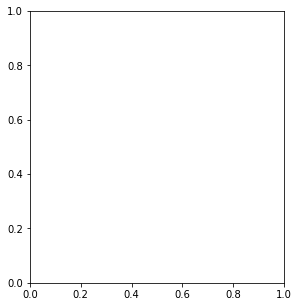

In [109]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_gaussian_quantiles


# Construct dataset
X1, y1 = make_gaussian_quantiles(cov=2.,
                                 n_samples=200, n_features=2,
                                 n_classes=2, random_state=1)
X2, y2 = make_gaussian_quantiles(mean=(3, 3), cov=1.5,
                                 n_samples=300, n_features=2,
                                 n_classes=2, random_state=1)
X = np.concatenate((X1, X2))
y = np.concatenate((y1, - y2 + 1))

# Create and fit an AdaBoosted decision tree
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",
                         n_estimators=200)

bdt.fit(X_train, y_train)

plot_colors = "br"
plot_step = 0.02
class_names = "AB"

plt.figure(figsize=(10, 5))

# Plot the decision boundaries
plt.subplot(121)
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

Z = bdt.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.axis("tight")

# Plot the training points
for i, n, c in zip(range(2), class_names, plot_colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1],
                c=c, cmap=plt.cm.Paired,
                s=20, edgecolor='k',
                label="Class %s" % n)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend(loc='upper right')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Decision Boundary')

# Plot the two-class decision scores
twoclass_output = bdt.decision_function(X)
plot_range = (twoclass_output.min(), twoclass_output.max())
plt.subplot(122)
for i, n, c in zip(range(2), class_names, plot_colors):
    plt.hist(twoclass_output[y == i],
             bins=10,
             range=plot_range,
             facecolor=c,
             label='Class %s' % n,
             alpha=.5,
             edgecolor='k')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, y1, y2 * 1.2))
plt.legend(loc='upper right')
plt.ylabel('Samples')
plt.xlabel('Score')
plt.title('Decision Scores')

plt.tight_layout()
plt.subplots_adjust(wspace=0.35)
plt.show()


In [ ]:
# Crossvalidation
# sklearn cross validation

In [ ]:
#  Grid Search for 2-3 hypaprameter in each model
#  sklearn grid search
# tuning your model to find the optimal hype